In [18]:
#Code to retrieve the full length sequences
from Bio import SeqIO
from Bio.SeqIO.FastaIO import FastaWriter

import pandas as pd
import numpy as np
from Bio import SeqIO
from bioinformatics import cluster, run_tantan

WT_length = {"TrpB": 389, "GB1": 56, "CreiLOV": 119}

# # Parse the table file to get sequence IDs
# hit_ids = []
# with open(tblout_file, "r") as tbl:
#     for line in tbl:
#         if not line.startswith("#"):  # Skip comments
#             cols = line.strip().split()
#             hit_ids.append(cols[0])  # Assuming the first column is the sequence ID

# # Extract sequences from the database
# with open(output_fasta, "w") as out_fasta:
#     writer = FastaWriter(out_fasta, wrap=None)
#     writer.write_header()
#     for record in SeqIO.parse(input_database, "fasta"):
#         if record.id in hit_ids:
#             writer.write_record(record)
#     writer.write_footer()

# print(f"Extracted {len(hit_ids)} sequences to {output_fasta}")

In [2]:
# # Parse a domain table file to extract aligned residue ranges
# def parse_domtblout(file_path):
#     ranges = []
#     with open(file_path, "r") as file:
#         for line in file:
#             if line.startswith("#") or not line.strip():
#                 continue  # Skip comments and empty lines
#             columns = line.split()
#             query_start = int(columns[15])  # Query start residue
#             query_end = int(columns[16])    # Query end residue
#             target_start = int(columns[17])  # Target start residue
#             target_end = int(columns[18])    # Target end residue
#             ranges.append({
#                 "query_start": query_start,
#                 "query_end": query_end,
#                 "target_start": target_start,
#                 "target_end": target_end
#             })
#     return ranges

# # Example usage
# domain_table = "/disk1/jyang4/repos/guided-discrete-diffusion/data/hmmer/jackhmmer/GB1.domtbl"  # Path to your domain table file
# aligned_ranges = parse_domtblout(domain_table)
# aligned_ranges

In [ ]:
#example usage to run hmmer search
!python hmmer/hmmer.py

In [19]:
#read fasta file
for method in ["jackhmmer"]: #"phmmer"
    for protein in ["TrpB", "GB1", "CreiLOV"]:
        sequences = SeqIO.parse(f"hmmer/{method}/{protein}_alignment.a2m", "fasta")
        print(f"Number of sequences in {method}/{protein}_alignment.a2m: {len(set([seq.seq for seq in sequences]))}")

Number of sequences in jackhmmer/TrpB_alignment.a2m: 173118
Number of sequences in jackhmmer/GB1_alignment.a2m: 126
Number of sequences in jackhmmer/CreiLOV_alignment.a2m: 403171


### Dataset filtering and resampling

In [ ]:
#save filtered sequences to fasta
# with open(f"raw_data/{protein}_alignment_filtered.fasta", "w") as f:
#     for i, row in df.iterrows():
#         f.write(f">{i}\n{row['Sequence'] }\n")

In [20]:
method = "jackhmmer"
protein = "CreiLOV"

In [21]:
sequences = SeqIO.parse(f"hmmer/{method}/{protein}_alignment.a2m", "fasta")  #alignment with dashes (use this with the diffusion models)
#sequences = SeqIO.parse(f"hmmer/{method}/{protein}/alignment.fasta", "fasta") #aligned portions of sequences (use this with the language models)
#sequences = SeqIO.parse(f"hmmer/{method}/{protein}_seqs.fasta", "fasta") #full sequences

seqs=list(set([str(s.seq) for s in sequences]))
parent_sequence = [SeqIO.read(f"{protein}/parent.fasta", "fasta")][0]

for i in range(0, len(seqs)):
    #remove lower case letters
    seqs[i] = ''.join([i for i in seqs[i] if not i.islower()])
    #replace dashes with corresponding amino acids in parent sequence
    seqs[i] = ''.join([parent_sequence.seq[j] if i == '-' else i for j, i in enumerate(seqs[i])]) #use this with the diffusion models

#drop sequences with length too short compared to WT
print(len(seqs))
seqs = [s for s in seqs if len(s) >= WT_length[protein]*0.75]
print(len(seqs))
#for CreiLOV, limit to length 1024 context window
seqs = [s for s in seqs if len(s) <= 1022]
print(len(seqs))
#also check that it's not too long for TrpB only, CreiLOV removes too many
seqs = [s for s in seqs if len(s) <= WT_length[protein]*1.25]
print(len(seqs))

403171
403171
403171
403171


In [22]:
seqs

['MAGLRHTFVVADATDSDGKIFSCNRAAEEIFGYTSEEFIGQSISMIMPRKHSVQHDQYLRNYIGGGAPKVGQFEAVRSNGEVFPIELAVSEIEEGPGQDRIFIGIVRDITERKKVERLA',
 'MAGLRHTFVVADAVAPDGTIVSWNRGGETIQGYRSEDILGQHVRVLYTADDQRAGIPELLQRAREEGRYETEGWRVRKDGTLFWANVVLTALYSPQGELLGYGRVVRDISDKKSATALA',
 'MAGLRHTFVVADFDLPAGNILSANDNFCQAMGYQLSDIIGKHHRFVEPADAASADYAAFWAGLGRGDFDQRQYKRIGKGGREVWIEASYNPVSTRGGKPYKVVKFATDITAQREGKALA',
 'MSTFQQTFVVSDATKPDHPILYASAGFFKMTGYTSKEVIGRNCRFLQGKETNPDDVAKIREALEKGNSYCGRLLNYKKDGTPFWNLLTIAPIKHDNGQVLKYIGMQIEVSKHTEGAALA',
 'MAGLRHTFVVADATLLDGAVLDANDNFLTAMGYTRDEVVGRHHSFVEPGYRESETYRAFWTALRNGTYQAAQFRRIGKGGREVWIQASYNPILDANGKPYKVVKFATDITDQVRGKALA',
 'MAGLSMPVLMVDAHRVGHPIVFANDAFRRLTGYSGDEVMGRSWQLLRGPATDPGTLDAVDAALRLGTAFETEILSCRKDGVPFWISVAVSPVHDEAGHLRGCTLLLSDISAKKQAERLA',
 'MAGLRHTFVVADATDRNGHITLINKVAERLTGWTRSEACGRPFEVFHDEHTGERCENPIEQVLIHRKTVENNTILISKQGVHIPIEDTAAPIIDAEGNITGVVVVFRDFTDKREKQKLA',
 'MAGLRHTFVVADATLPDCPIRASNAAACKLFGYSPTHICNLNLETLHLETAAFESFDLLREALRSEAHFFTEWPLRRADNSVFPAELRIRRLNSPDCAEQLFIAVISDLTEKYAGKALA',
 'MAGLRH

In [18]:
#save reference sequences with dashes in the alignment (not just the aligned positions)
with open(f"{protein}/reference_aligned.fasta", "w") as f:
    for i, s in enumerate(seqs):
        f.write(f">{i}\n{s}\n")

In [2]:
#get the length of characters, not including '-'
def length(seq):
    return len([i for i in seq if i != '-'])

(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0., 126.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.]),
 array([55.5 , 55.52, 55.54, 55.56, 55.58, 55.6 , 55.62, 55.64, 55.66,
        55.68, 55.7 , 55.72, 55.74, 55.76, 55.78, 55.8 , 55.82, 55.84,
        55.86, 55.88, 55.9 , 55.92, 55.94, 55.96, 55.98, 56.  , 56.02,
        56.04, 56.06, 56.08, 56.1 , 56.12, 56.14, 56.16, 56.18, 56.2 ,
        56.22, 56.24, 56.26, 56.28, 56.3 , 56.32, 56.34, 56.36, 56.38,
        56.4 , 56.42, 56.44, 56.46, 56.48, 56.5 ]),
 <BarContainer object of 50 artists>)

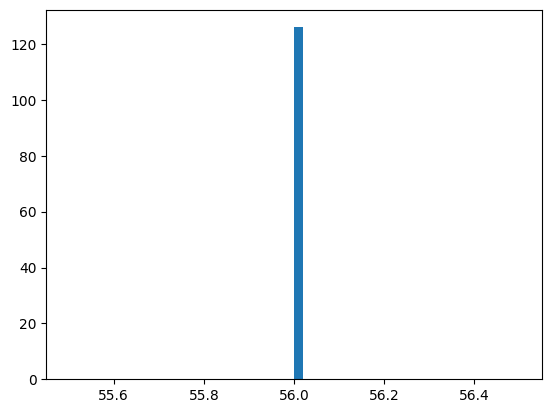

In [19]:
#histogram of sequence lengths
lengths = [len(s) for s in seqs]
import matplotlib.pyplot as plt
plt.hist(lengths, bins=50)

In [31]:
seqs[:10]

['VEQAAVAISITDTRARIVYANPCFEQVTGYTAEEIIGRNQSILSYKVTPRLVYESLWAQLARKEPWNGLLVNRRQDGSRYLADLTITPVMNDAGEVTHFLGLHRDVTEVHQLE',
 'SVIITDRERRIVYVNRGFTAVSGYGADEAMGRDPRELKRATGDAAAEAAMDATVAAGTGWVGRLTNRKKSGELYFEQAVITPVRDARGEITNYVAIGRDVTAEMRR',
 'ILDQTDRIEWVNDAYTRTTGYSLAEAVGRFPGDLLNSPQTDPASLAKLEHSRKTRTPVRVEILNRSKDGRLMWIETSINPIFDAYGKLQLWIAVERDISEAKQRE',
 'TRMEDGVFIEVNKGFEQWTGWKKEELVGRSSLDIGLWSPEARARAVAITREQGRLVNYEFVLGTKSGEKRSAVMYLTPITIQGEECLYFMVRDITESKLAE',
 'IVMTDAQGIIQFVNPAFKRITGYRGREAVGQNSRILKSGVQDEQFYHDLWSTISGGDTWSGRMVNRHKDGTFYTDETTISPVRDASDRIVNYVAVKRDITEHL',
 'GDFGINYVSNSIEEITGYAPECFTGDAAFWADHLLPEDGRKVVDELPILLEKGRQRCEYRFRTADGSYRWFDDTRRLVHSPDGSCSHIAGTWRDVTEEKRLR',
 'EGRYVALNESAWRARGLGAADVLGRTAAELFPPDVVAERLAHDRAVLESGGPVLIEHQETGPDGAPRWYETVKAPYRDAAGSIAGTVGIARDITGRRRLE',
 'LKRRIFLFNRAAERITGFNKEEVLGKDCHEVFPGKFCGEKCSFCRLGTPGLDELDKEYSVSLVSKDGKKRTITMNLFPIEGPNKKPLGVVAAFRDITEELR',
 'DADGRFLSVNARFCSMAGRRSEELLRLRMRDITHPDDRAVSETALRSAALDGEPATVEKRLVRPDGTTLWVTNTKSAIAGMAGRRNVLVVAIDIEERKAAER',
 'QDRQFRYVNHRFQELTGYRE

In [18]:
# df = run_tantan(seqs)
# df

In [25]:
len(seqs)

126

In [23]:
df = cluster(seqs, 0.8).reset_index()
#drop the column called 1
df = df.drop(columns=[1])
df

,sequence,cluster_80
0,MAGLRHTFVVADATLPDCPLVYASEGFYAMTGYGSSDIIGSNARFL...,106939
1,MAGLRHTFVVADATLPTGKFRYVNPALCNMLGYTEEELMQIRLNDL...,106940
2,MAGLRHSVAILCKNEWNFPIEFASENSIQLFGYSHNELLSNKINIH...,106941
3,MAGLRHTFNAIMITDEKGIIEWVNDSFIRLTQYNIDEVLGLSPRLL...,106942
4,MAGTSCSFIICDLSLPHTPIIYASGPFSQMTGYTANEVMGMNPRFM...,106943
...,...,...
403017,MAGLRHTFVVADATDDEHRFRWFSPSFDAVVGMSAASLLGKRREEL...,400312
403018,MAGLRHTFVVADATDADHRFRWFSPSFEVVLGTSPDALLGKRREEL...,400312
403019,MAGLRHTFVVADARLSDGHFIDANDAFLGLFGYTREEAVGHSALEL...,400315
403020,MAGLRHTSHLVLITDPEGRIVWVNRAYTRLSGYGADEARGRRPRLL...,400316


In [ ]:
#for TrpB, to augment the data. loop through each sequence and make random single mutations to the beginning of the sequence to prevent 
if protein == "TrpB":
    n_mutate_to = 40
elif protein == "CreiLOV":
    n_mutate_to = 10

seqs = []
ids = []

for i, row in df.iterrows():
    seq = row['sequence']
    cluster_id = row["cluster_80"]

    for j in range(1, n_mutate_to): #in this case, do not mutate the M at the first position
        #randomly sample a choice from 'ACDEFGHIKLMNPQRSTVWY'
        new_aa = np.random.choice(list('ACDEFGHIKLMNPQRSTVWY'))
        if seq[j] != new_aa:
            #make a random mutation
            new_seq = list(seq)
            new_seq[j] = new_aa
            new_seq = ''.join(new_seq)
            #add a new row to the dataframe
            seqs.append(new_seq)
            ids.append(cluster_id)

#append to df
df_augmented = pd.DataFrame({'sequence': seqs, 'cluster_80': ids})
df = pd.concat([df, df_augmented], ignore_index=True)
df


,sequence,cluster_80
0,MAGLRHTFVVADATLPDCPLVYASEGFYAMTGYGSSDIIGSNARFL...,106939
1,MAGLRHTFVVADATLPTGKFRYVNPALCNMLGYTEEELMQIRLNDL...,106940
2,MAGLRHSVAILCKNEWNFPIEFASENSIQLFGYSHNELLSNKINIH...,106941
3,MAGLRHTFNAIMITDEKGIIEWVNDSFIRLTQYNIDEVLGLSPRLL...,106942
4,MAGTSCSFIICDLSLPHTPIIYASGPFSQMTGYTANEVMGMNPRFM...,106943
...,...,...
3848321,MAGLRQTFVVADATLSEYRIVEWNPGAAKLFGYEKEETAGKNLDEL...,400318
3848322,MAGLRHEFVVADATLSEYRIVEWNPGAAKLFGYEKEETAGKNLDEL...,400318
3848323,MAGLRHTCVVADATLSEYRIVEWNPGAAKLFGYEKEETAGKNLDEL...,400318
3848324,MAGLRHTFDVADATLSEYRIVEWNPGAAKLFGYEKEETAGKNLDEL...,400318


In [38]:
#for GB1, to augment the data. loop through each sequence and make random single mutations
seqs = []
ids = []

for i, row in df.iterrows():
    seq = row['sequence']
    cluster_id = row["cluster_80"]
    
    for j in range(len(seq)):
        for new_aa in 'ACDEFGHIKLMNPQRSTVWY':
            if seq[j] != new_aa:
                #make a random mutation
                new_seq = list(seq)
                new_seq[j] = new_aa
                new_seq = ''.join(new_seq)
                #add a new row to the dataframe
                seqs.append(new_seq)
                ids.append(cluster_id)

#append to df
df_augmented = pd.DataFrame({'sequence': seqs, 'cluster_80': ids})
df = pd.concat([df, df_augmented], ignore_index=True)
df


,sequence,cluster_80
0,MTYKLVVKTADTNITSEYDAANKEAAEEYFHAYVARNGLELNWTYD...,0
1,MTYKLVVKGNTFSGETTTKAVDAATAEKEFKQYAIANGVDGEWTYD...,1
2,MTYKLILNGKTFKGETTTKAVDAATAEKEFKQYANDNGADGVWSYD...,1
3,MTYKLVVKGNSFSGETTTKAVDAETAEKAFKQYANENGVDGVWTYD...,1
4,MTYKLVINGKTLKGETTTKAVDAETAEKAFKQYANDNGVDGEWTYD...,1
...,...,...
128876,MTYKLILNGKTHKGVLTIEAVDAATAEKHFKQHANDLGVDGEWTYD...,122
128877,MTYKLILNGKTHKGVLTIEAVDAATAEKHFKQHANDLGVDGEWTYD...,122
128878,MTYKLILNGKTHKGVLTIEAVDAATAEKHFKQHANDLGVDGEWTYD...,122
128879,MTYKLILNGKTHKGVLTIEAVDAATAEKHFKQHANDLGVDGEWTYD...,122


In [42]:
df["cluster_80"].nunique()

36

In [25]:
value_counts = df['cluster_80'].value_counts()
df['cluster80size'] = df['cluster_80'].apply(lambda x: value_counts[x])
df['weighted_prob'] = df['cluster80size'].apply(lambda x: 1/ (1+ np.log(x)))
#sampled_df = df.sample(frac=1, weights='weighted_prob', random_state=42, replace=True) 

#sample less for TrpB
sampled_df = df.sample(frac=1./n_mutate_to, weights='weighted_prob', random_state=42, replace=True) 
sampled_df

,sequence,cluster_80,cluster80size,weighted_prob
1450422,MAGLRVTFVVADATADWDELLFINSAFEEIWGIPIETLEDTPDAFL...,45645,30,0.227211
3655679,MAGLRDTFVVADATLPDLRWTYLTPAFETIYGIDRSRALSNNYRDL...,393834,9,0.312771
2823333,MAGLRHTMVVADVTDAKATILTVNDAFIRLTGFTEGETLGKNPQIL...,362294,10,0.302793
2311700,MAGLRHTFTVADAHSLDMKFTYADDKMEGFLGYNPESLLGKSVYDF...,23073,9,0.312771
604097,MALLRHTFVGVNIQDNEGITTWVNQSLEKLTGYKKEELYGHHGNIL...,50542,67,0.192134
...,...,...,...,...
390083,MAGLRHTFVVADATLMEGNLVLFNHALVDILGLPEDELRERNTEFM...,300552,10,0.302793
987158,MAGLRHHFVIEDATDTETRIIYASPRAAQILGESPQALLGRSLEFI...,185119,28,0.230829
2097310,MAGLRHTEVVADATDTDHRIFFWNKAAVQFFGFTDEEVFQQPLEKI...,396096,10,0.302793
3334434,MATLRHTFVVADATLPDGGITDWWQGAEAVFGWTRAEVLGMDIRVL...,402019,9,0.312771


In [26]:
np.random.seed(42)
test_clusters = sampled_df["cluster_80"].unique()
test_clusters = np.random.choice(test_clusters, int(len(test_clusters)*0.05), replace=False)
sampled_df["Split"] = sampled_df["cluster_80"].apply(lambda x: x in test_clusters)
#map True to validation and False to training
sampled_df["Split"] = sampled_df["Split"].apply(lambda x: "validation" if x else "train")
sampled_df

,sequence,cluster_80,cluster80size,weighted_prob,Split
1450422,MAGLRVTFVVADATADWDELLFINSAFEEIWGIPIETLEDTPDAFL...,45645,30,0.227211,train
3655679,MAGLRDTFVVADATLPDLRWTYLTPAFETIYGIDRSRALSNNYRDL...,393834,9,0.312771,train
2823333,MAGLRHTMVVADVTDAKATILTVNDAFIRLTGFTEGETLGKNPQIL...,362294,10,0.302793,train
2311700,MAGLRHTFTVADAHSLDMKFTYADDKMEGFLGYNPESLLGKSVYDF...,23073,9,0.312771,train
604097,MALLRHTFVGVNIQDNEGITTWVNQSLEKLTGYKKEELYGHHGNIL...,50542,67,0.192134,validation
...,...,...,...,...,...
390083,MAGLRHTFVVADATLMEGNLVLFNHALVDILGLPEDELRERNTEFM...,300552,10,0.302793,train
987158,MAGLRHHFVIEDATDTETRIIYASPRAAQILGESPQALLGRSLEFI...,185119,28,0.230829,train
2097310,MAGLRHTEVVADATDTDHRIFFWNKAAVQFFGFTDEEVFQQPLEKI...,396096,10,0.302793,train
3334434,MATLRHTFVVADATLPDGGITDWWQGAEAVFGWTRAEVLGMDIRVL...,402019,9,0.312771,train


In [27]:
sampled_df.to_csv(f"{protein}/MSA.csv")

In [45]:
df[df["Split"] == "validation"]

,sequence,cluster_80,cluster80size,weighted_prob,Split
106,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYD...,122,15979,0.093641,validation
107,MTFKLIINGKTLKGETTTEAVDAATAEKVFKQYANDNGLDGEWTYD...,122,15979,0.093641,validation
108,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYFNDNGVDGEWTYD...,122,15979,0.093641,validation
109,MTYKLVINGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYD...,122,15979,0.093641,validation
110,MQYKVILNGKTLKGETTTEAVDAATFEKVVKQFFNDNGVDGEWTYD...,122,15979,0.093641,validation
...,...,...,...,...,...
128876,MTYKLILNGKTHKGVLTIEAVDAATAEKHFKQHANDLGVDGEWTYD...,122,15979,0.093641,validation
128877,MTYKLILNGKTHKGVLTIEAVDAATAEKHFKQHANDLGVDGEWTYD...,122,15979,0.093641,validation
128878,MTYKLILNGKTHKGVLTIEAVDAATAEKHFKQHANDLGVDGEWTYD...,122,15979,0.093641,validation
128879,MTYKLILNGKTHKGVLTIEAVDAATAEKHFKQHANDLGVDGEWTYD...,122,15979,0.093641,validation


In [28]:
from visualization import plot_logo, process_logo

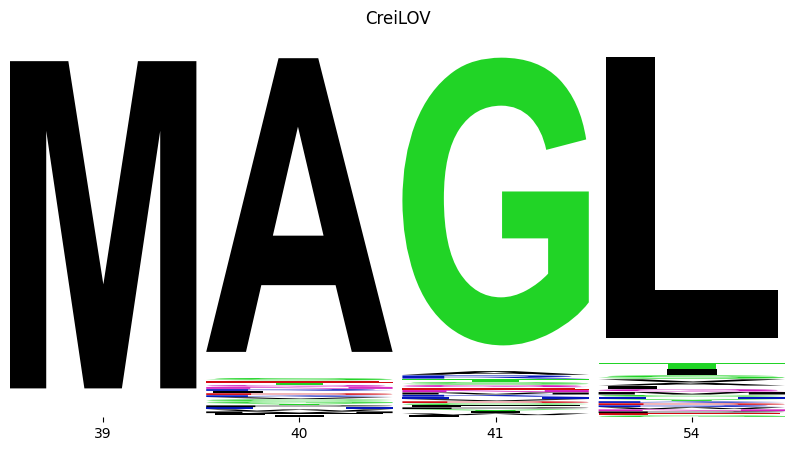

In [29]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 5))
plot_logo(process_logo(df, sites=[1, 2, 3, 4]), protein, ax, sites=[39, 40, 41, 54])
# plot_logo(process_logo(df, sites=[39, 40, 41, 54]), protein, ax, sites=[39, 40, 41, 54])

In [57]:
df.to_csv(f"{protein}/MSA.csv", index=False)
#df.to_csv(f"{protein}/MSA_aligned.csv", index=False)

In [ ]:
pd.read_csv(f"TrpB/MSA.csv")

NameError: name 'pd' is not defined

### Save 1000 random sequences as a fasta

In [ ]:
sites = [117, 118, 119, 162, 166, 182, 183, 184, 185, 186, 227, 228, 230, 231, 301]

parent = "MKGYFGPYGGQYVPEILMGALEELEAAYEGIMKDESFWKEFNDLLRDYAGRPTPLYFARRLSEKYGARVYLKREDLLHTGAHKINNAIGQVLLAKLMGKTRIIAETGAGQHGVATATAAALFGMECVIYMGEEDTIRQKLNVERMKLLGAKVVPVKSGSRTLKDAIDEALRDWITNLQTTYYVFGSVVGPHPYPIIVRNFQKVIGEETKKQIPEKEGRLPDYIVACVSGGSNAAGIFYPFIDSGVKLIGVEAGGEGLETGKHAASLLKGKIGYLHGSKTFVLQDDWGQVQVSHSVSAGLDYSGVGPEHAYWRETGKVLYDAVTDEEALDAFIELSRLEGIIPALESSHALAYLKKINIKGKVVVVNLSGRGDKDLESVLNHPYVRERIR"
#map back positions that are not in sites to the parent
vocab = "ACDEFGHIKLMNPQRSTVWY"

def map_back(seq, sites):
    mapped_seq = ""
    for i in range(len(seq)):
        if i+1 in sites:
            #print if not in vocab
            if seq[i] not in vocab:
                print(f"Not in vocab: {seq[i]} at position {i+1}") 
                #replace with a random letter
                mapped_seq += np.random.choice(list(vocab))
            else:
                mapped_seq += seq[i]
        else:
            mapped_seq += parent[i]
        
        
    return mapped_seq

In [7]:
np.random.seed(42)
for name in ["GB1/MSA"]: #["TrpB/MSA", "CreiLOV/MSA"]:
    df = pd.read_csv(f"{name}.csv")
    df = df[df["Split"] == "train"]
    #drop sequences that contain X
    df = df[~df["sequence"].str.contains("X")]
    #sample 1000 rows
    df = df.sample(1000, random_state=42)
    #save to fasta
    if name == "TrpB_MSA":
        df["sequence"] = df["sequence"].apply(lambda x: map_back(x, sites))
    #check rows for characters not in vocab
        
    with open(f"{name}_sample.fasta", "w") as f:
        for i, row in df.iterrows():
            f.write(f">{i}\n{row['sequence']}\n")

In [10]:
for name in ["GB1/MSA"]: #["TrpB/MSA", "CreiLOV/MSA"]:
    df = pd.read_csv(f"{name}.csv")
    df = df[df["Split"] == "train"]
    #drop sequences that contain X
    #df = df[~df["sequence"].str.contains("X")]
df

,sequence,cluster_80,cluster80size,weighted_prob,Split,combo,AA0,AA1,AA2,AA3,...,AA46,AA47,AA48,AA49,AA50,AA51,AA52,AA53,AA54,AA55
0,MTYKLVVKTADTNITSEYDAANKEAAEEYFHAYVARNGLELNWTYD...,0,1065,0.125459,train,LELV,L,E,L,V,...,A,E,T,K,T,F,M,V,T,E
1,MTYKLVVKGNTFSGETTTKAVDAATAEKEFKQYAIANGVDGEWTYD...,1,52197,0.084297,train,VDGV,V,D,G,V,...,D,A,T,K,T,F,T,V,T,E
2,MTYKLILNGKTFKGETTTKAVDAATAEKEFKQYANDNGADGVWSYD...,1,52197,0.084297,train,ADGV,A,D,G,V,...,D,A,T,K,T,F,T,V,T,E
3,MTYKLVVKGNSFSGETTTKAVDAETAEKAFKQYANENGVDGVWTYD...,1,52197,0.084297,train,VDGV,V,D,G,V,...,D,A,T,K,T,F,T,V,T,E
4,MTYKLVINGKTLKGETTTKAVDAETAEKAFKQYANDNGVDGEWTYD...,1,52197,0.084297,train,VDGV,V,D,G,V,...,D,A,T,K,T,F,T,V,T,E
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112912,MTYHFTYKGADTTVSTDHVAGSVDKAEQYFRAYASESGLNLDFTYD...,118,2130,0.115422,train,LNLG,L,N,L,G,...,E,A,T,H,T,F,V,G,T,S
112913,MTYHFTYKGADTTVSTDHVAGSVDKAEQYFRAYASESGLNLDFTYD...,118,2130,0.115422,train,LNLG,L,N,L,G,...,E,A,T,H,T,F,V,G,T,T
112914,MTYHFTYKGADTTVSTDHVAGSVDKAEQYFRAYASESGLNLDFTYD...,118,2130,0.115422,train,LNLG,L,N,L,G,...,E,A,T,H,T,F,V,G,T,V
112915,MTYHFTYKGADTTVSTDHVAGSVDKAEQYFRAYASESGLNLDFTYD...,118,2130,0.115422,train,LNLG,L,N,L,G,...,E,A,T,H,T,F,V,G,T,W


In [8]:
df

#check to make sure seuqences in df only contain characters in vocab
vocab = "ACDEFGHIKLMNPQRSTVWY"
for i, row in df.iterrows():
    for c in row['sequence']:
        if c not in vocab:
            print(f"Not in vocab: {c} at position {i+1}") 
            #replace with a random letter
            df.at[i, 'sequence'] = df.at[i, 'sequence'].replace(c, np.random.choice(list(vocab)))

